In [2]:
pip install pandas scikit-learn matplotlib pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=cfb6e7c871634387dd9772a14d3da4b78583d7d87fcffd732ec147c2f30e8677
  Stored in directory: /root/.cache/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


In [3]:
!pip uninstall numpy
!pip install numpy==1.23.5

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_intern

In [1]:
# Import thư viện
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from pyclustering.cluster.xmeans import xmeans, kmeans_plusplus_initializer
from pyclustering.cluster.center_initializer import random_center_initializer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import timedelta

In [2]:
# Load dữ liệu
train_df = pd.read_csv("train.csv", parse_dates=["date"])
valid_df = pd.read_csv("validation.csv", parse_dates=["date"])
test_df = pd.read_csv("test.csv", parse_dates=["date"])

# Đặc trưng và mục tiêu
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values
X_valid = valid_df[features].values
y_valid = valid_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values

# Chuẩn hóa
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
X_valid = scaler_X.transform(X_valid)
y_valid = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Gộp dữ liệu train + valid để clustering và ensemble
X_all = np.concatenate((X_train, X_valid), axis=0)
y_all = np.concatenate((y_train, y_valid), axis=0)

In [3]:
# Clustering với X-Means
initial_centers = kmeans_plusplus_initializer(X_all, 2).initialize()
xmeans_instance = xmeans(X_all, initial_centers, kmax=5)
xmeans_instance.process()
labels = np.array(xmeans_instance.get_clusters())

# Tạo tập dữ liệu từ clustering
clustered_datasets = []
for cluster_indices in labels:
    cluster_X = X_all[cluster_indices]
    cluster_y = y_all[cluster_indices]
    clustered_datasets.append((cluster_X, cluster_y))

# Huấn luyện các mô hình cho từng cụm và kết hợp bằng Voting Regressor
models = []
for i, (cX, cY) in enumerate(clustered_datasets):
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    svr = SVR()
    voting = VotingRegressor([('lr', lr), ('rf', rf), ('svr', svr)])
    voting.fit(cX, cY)
    models.append(voting)

# Dự đoán bằng trung bình kết quả từ các mô hình trong cụm gần nhất
from sklearn.metrics.pairwise import euclidean_distances
cluster_centers = np.array([np.mean(c[0], axis=0) for c in clustered_datasets])

def ensemble_predict(X):
    preds = []
    for x in X:
        dists = euclidean_distances([x], cluster_centers).flatten()
        closest_idx = np.argmin(dists)
        pred = models[closest_idx].predict([x])[0]
        preds.append(pred)
    return np.array(preds)

<ipython-input-3-807527be356a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array(xmeans_instance.get_clusters())


In [5]:
# Đánh giá trên tập validation và test
val_preds = ensemble_predict(X_valid)
val_preds_inv = scaler_y.inverse_transform(val_preds.reshape(-1, 1)).flatten()
y_valid_inv = scaler_y.inverse_transform(y_valid.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_valid_inv, val_preds_inv)
rmse = mean_squared_error(y_valid_inv, val_preds_inv) ** 0.5
r2 = r2_score(y_valid_inv, val_preds_inv)
print(f"Validation - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

test_preds = ensemble_predict(X_test)
test_preds_inv = scaler_y.inverse_transform(test_preds.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_inv, test_preds_inv)
rmse = mean_squared_error(y_test_inv, test_preds_inv) ** 0.5
r2 = r2_score(y_test_inv, test_preds_inv)
print(f"Test - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

Validation - MAE: 1450883.19, RMSE: 5793414.36, R2: 0.97
Test - MAE: 1366463.09, RMSE: 3625002.24, R2: 0.99


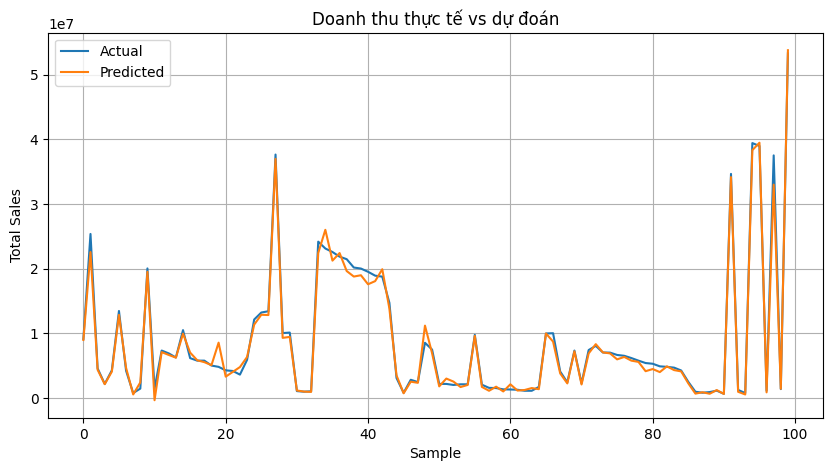

In [6]:
# Vẽ biểu đồ so sánh
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(test_preds_inv[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

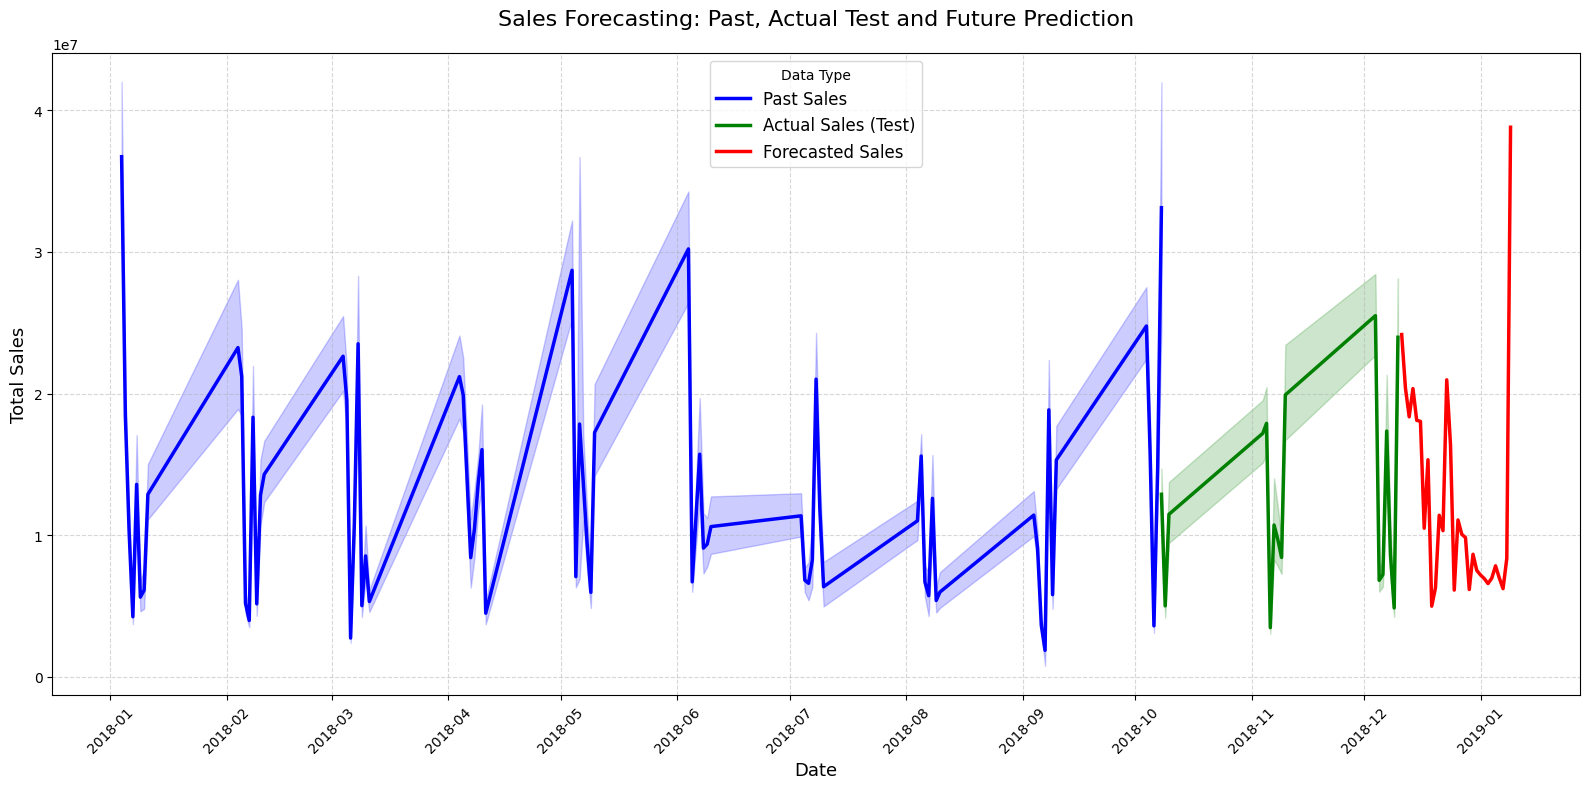

,Date,Predicted Sales
0,2018-12-11,2.416838e+07
1,2018-12-12,2.039468e+07
2,2018-12-13,1.835994e+07
3,2018-12-14,2.035389e+07
4,2018-12-15,1.811206e+07
5,2018-12-16,1.803877e+07
6,2018-12-17,1.049732e+07
7,2018-12-18,1.533040e+07
8,2018-12-19,4.991130e+06
9,2018-12-20,6.290311e+06


In [7]:
# Dự đoán 30 ngày tiếp theo
last_date = test_df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30).strftime('%Y-%m-%d')
future_X_raw = test_df[features].iloc[-30:].values
future_X_scaled = scaler_X.transform(future_X_raw)
future_preds_scaled = ensemble_predict(future_X_scaled)
future_sales = scaler_y.inverse_transform(future_preds_scaled.reshape(-1, 1)).flatten()

future_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_sales,
    'type': 'Forecasted Sales'
})

train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'

combined_df = pd.concat([train_df, valid_df, test_df, future_df], ignore_index=True)

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()

future_df[['date', 'total_sales']].rename(columns={'date': 'Date', 'total_sales': 'Predicted Sales'})
